# 实验参数设置

In [ ]:
from FederatedLearning.learner import CNNModel

clients_num = 10 # 客户端总数
rotation_cycle = 5 # 角色轮换间隔轮数
max_round = 20 # 联邦学习轮数
learning_rate = 0.01
model_class = CNNModel # 选用CNN模型

## 数据切分

In [ ]:
import data_split
# 使用data_split模块中的函数获取PyTorch数据集
train_dataset = data_split.get_mnist_pytorch_dataset(train=True)
test_dataset = data_split.get_mnist_pytorch_dataset(train=False)
# test
# 使用正确的数据集对象创建数据加载器
client_dataloaders = data_split.create_client_dataloaders(train_dataset, clients_num // 2, 64, num_workers=clients_num) * 2
client_test_loader = data_split.create_client_dataloaders(test_dataset, clients_num // 2, 64) * 2

## 开始训练
### 无恶意客户端训练

In [ ]:
from owner import Owner
from client import Client, BadClient
    
    
# 初始化管理者，并获得初始化字典
owner = Owner(rotation_cycle=1, model_class=model_class)
main_dict = owner.get_main_dict()

# 初始化客户端以及身份
clients = [owner]
for i in range(clients_num):
    client_name = f"client_{i + 1}"
    client = Client(epochs=2, client_name=client_name, data_loader=client_dataloaders[i],
                    test_loader=client_test_loader[i], ModelClass=model_class, main_dict=main_dict, learning_rate=learning_rate)
    owner.join(client_name)
    clients.append(client)

import threading

for _ in range(max_round):
    t = [threading.Thread(target=client.run) for client in clients]
    _ = [i.start() for i in t]
    _ = [i.join() for i in t]

    


# 保存实验过程和结果
import pickle
with open(f"main_dict_{clients_num}_{0}.pkl", "wb") as f:
    pickle.dump(main_dict, f)

### 有恶意客户端训练
#### 恶意客户端 占比 10%

In [ ]:
from owner import Owner
from client import Client, BadClient

bad_percent = 0.1
bad_num = int(clients_num * bad_percent)
    
# 初始化管理者，并获得初始化字典
owner = Owner(rotation_cycle=1, model_class=model_class)
main_dict = owner.get_main_dict()

# 初始化客户端以及身份
clients = [owner]
for i in range(clients_num-bad_num):
    client_name = f"client_{i + 1}"
    client = Client(epochs=2, client_name=client_name, data_loader=client_dataloaders[i],
                    test_loader=client_test_loader[i], ModelClass=model_class, main_dict=main_dict, learning_rate=learning_rate)
    owner.join(client_name)
    clients.append(client)
for i in range(bad_num):
    client_name = f"bad_client_{i + 1}"
    client = BadClient(epochs=2, client_name=client_name, data_loader=client_dataloaders[i],
                    test_loader=client_test_loader[i], ModelClass=model_class, main_dict=main_dict, learning_rate=learning_rate)
    owner.join(client_name)
    clients.append(client)
    
import threading

for _ in range(max_round):
    t = [threading.Thread(target=client.run) for client in clients]
    _ = [i.start() for i in t]
    _ = [i.join() for i in t]

    


# 保存实验过程和结果
import pickle
with open(f"main_dict_{clients_num}_{bad_percent}.pkl", "wb") as f:
    pickle.dump(main_dict, f)

## 计算结果可视化

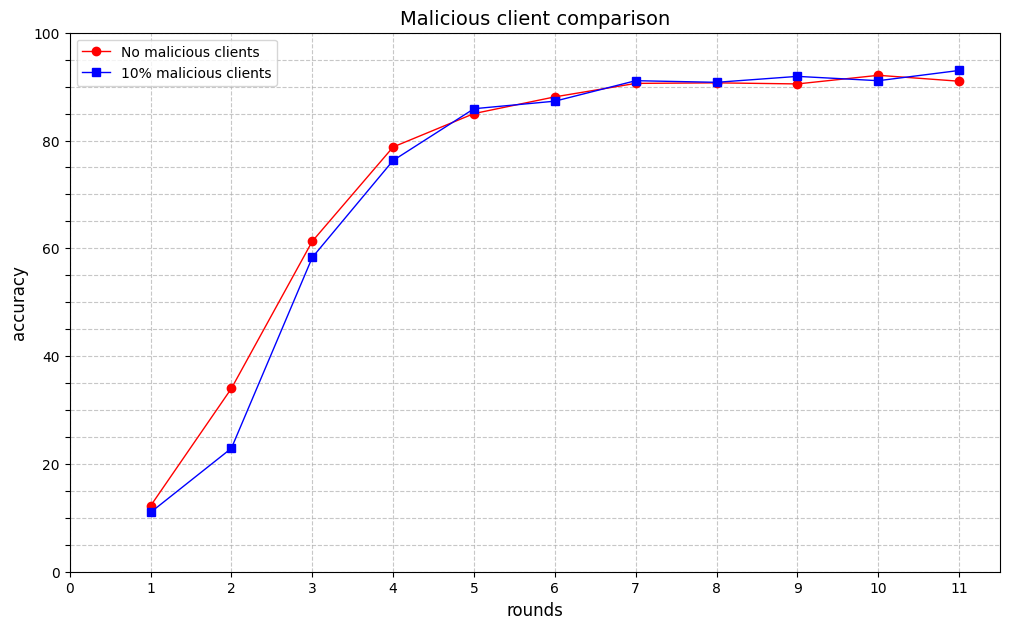

In [1]:
import pickle
from matplotlib import pyplot as plt

# 创建图形
plt.figure(figsize=(12, 7))
client_num = 10
bad_rate = 0.1
path_li = [f"main_dict_{client_num}_0.pkl", f"main_dict_{client_num}_{bad_rate * 100}.pkl"]
marker_options = [("o", "red"), ["s", "blue"]]
label_options = ["No malicious clients", "10% malicious clients"]
round_num = 0
for path, marker_option, label_option in zip(path_li, marker_options, label_options):
    main_dict = pickle.load(open(path, "rb"))
    # 精确度变化可视化
    global_accuracy_history = main_dict["global_accuracy_history"]    
    # 绘制主要曲线
    epochs = list(range(1, len(global_accuracy_history) + 1))
    plt.plot(epochs, global_accuracy_history, marker_option[1], label=label_option, linewidth=1, marker=marker_option[0], markersize=6, 
             markerfacecolor=marker_option[1])
    if len(epochs) > round_num:
        round_num = len(epochs)

plt.ylim(0, 100)
# 添加标题和标签
plt.title('Malicious client comparison', fontsize=14)
plt.xlabel('rounds', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
# 添加图例和网格
plt.legend(loc='best', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
# 设置 X 轴刻度
plt.xticks([i for i in range(0, round_num + 1, 1)])

# 设置 Y 轴刻度
plt.yticks([i for i in range(0, 101, 5)], [i if i % 20 == 0 else "" for i in range(0, 101, 5)])
# 显示图表
plt.show()
    




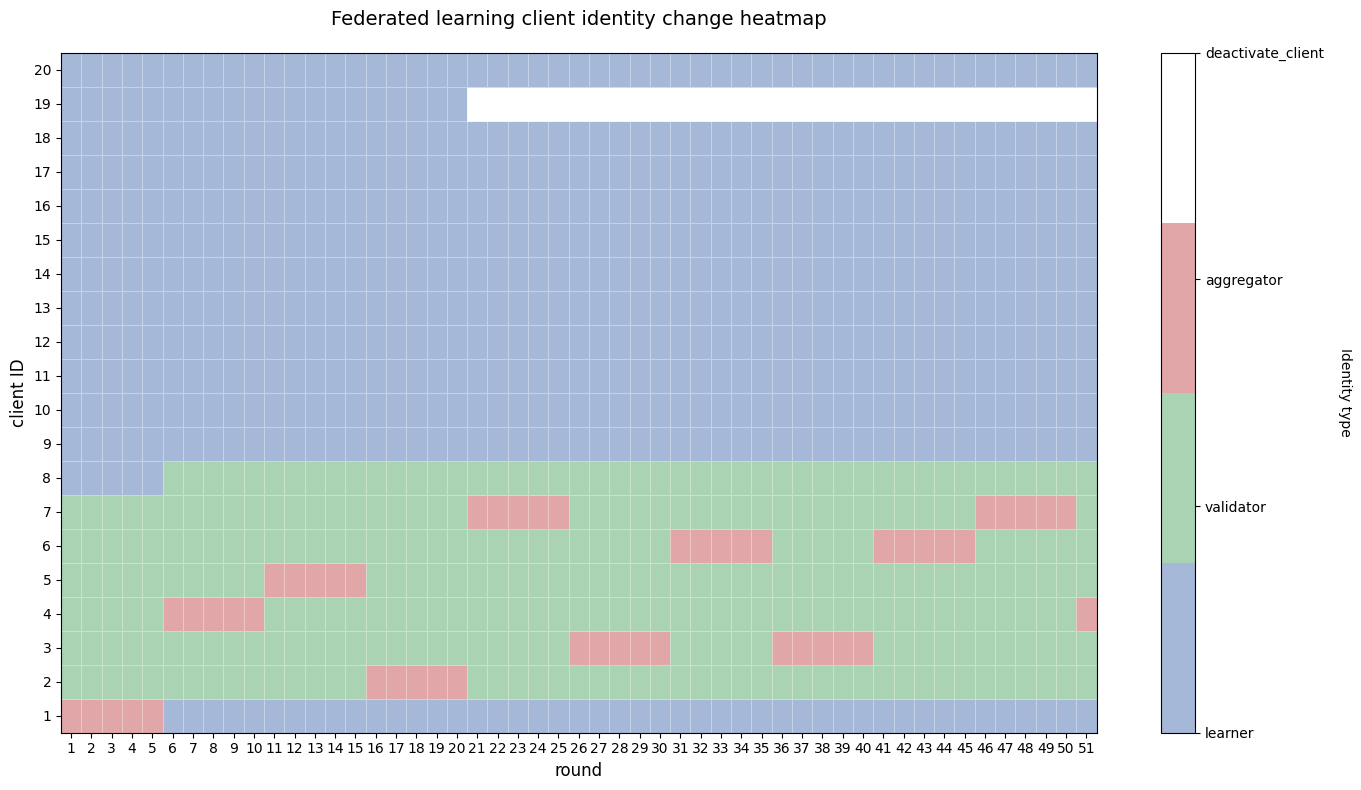

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pickle  # 添加pickle模块

# 加载数据
main_dict = pickle.load(open("main_dict_20_10.0.pkl", "rb"))
global_accuracy_history = main_dict["global_accuracy_history"]
role_history = main_dict["role"]

def role_to_nums(role: str):
    if role == "learner":
        return 0
    elif role == "validator":
        return 1
    elif role == "aggregator":
        return 2
    else:
        return 3

def client_to_nums(client: str):
    if client.startswith("client"):
        return int(client[7:])
    elif client.startswith("bad_client"):
        return 100 + int(client[11:])
    else:
        return -1

num_rounds = len(global_accuracy_history)
num_clients = len(role_history[0].keys())
identity_data = np.array([
    [role_to_nums(role) for client, role in sorted(role_history[i].items(), key=lambda x: client_to_nums(x[0]))]
    for i in range(num_rounds)
])

# 创建自定义颜色映射
colors = ["#4C72B0", "#55A868", "#C44E52", "#FFFFFF"]  # 蓝、绿、红、白
cmap = mcolors.ListedColormap(colors)

# 创建图表
plt.figure(figsize=(14, 8))

# 使用pcolormesh绘制热力图并添加分割线
# 注意：pcolormesh需要网格坐标，比数据维度多1
x = np.arange(num_rounds + 1)
y = np.arange(num_clients + 1)

# 绘制热力图并添加白色分割线
mesh = plt.pcolormesh(x, y, identity_data.T, 
                      cmap=cmap, 
                      edgecolor='white',  # 设置分割线颜色
                      linewidth=0.5,      # 设置分割线宽度
                      alpha=0.5)          # 设置透明度

# 设置坐标轴
plt.xlabel('round', fontsize=12)
plt.ylabel('client ID', fontsize=12)
plt.title('Federated learning client identity change heatmap', fontsize=14, pad=20)

# 设置刻度位置在单元格中心
plt.xticks(np.arange(num_rounds) + 0.5, np.arange(1, num_rounds + 1))
plt.yticks(np.arange(num_clients) + 0.5, np.arange(1, num_clients + 1))

# 添加颜色条
cbar = plt.colorbar(mesh, ticks=[0, 1, 2, 3])
cbar.set_ticklabels(['learner', 'validator', 'aggregator', "deactivate_client"])
cbar.set_label('Identity type', rotation=270, labelpad=20)

# 优化布局
plt.tight_layout()
plt.show()

(20,)


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

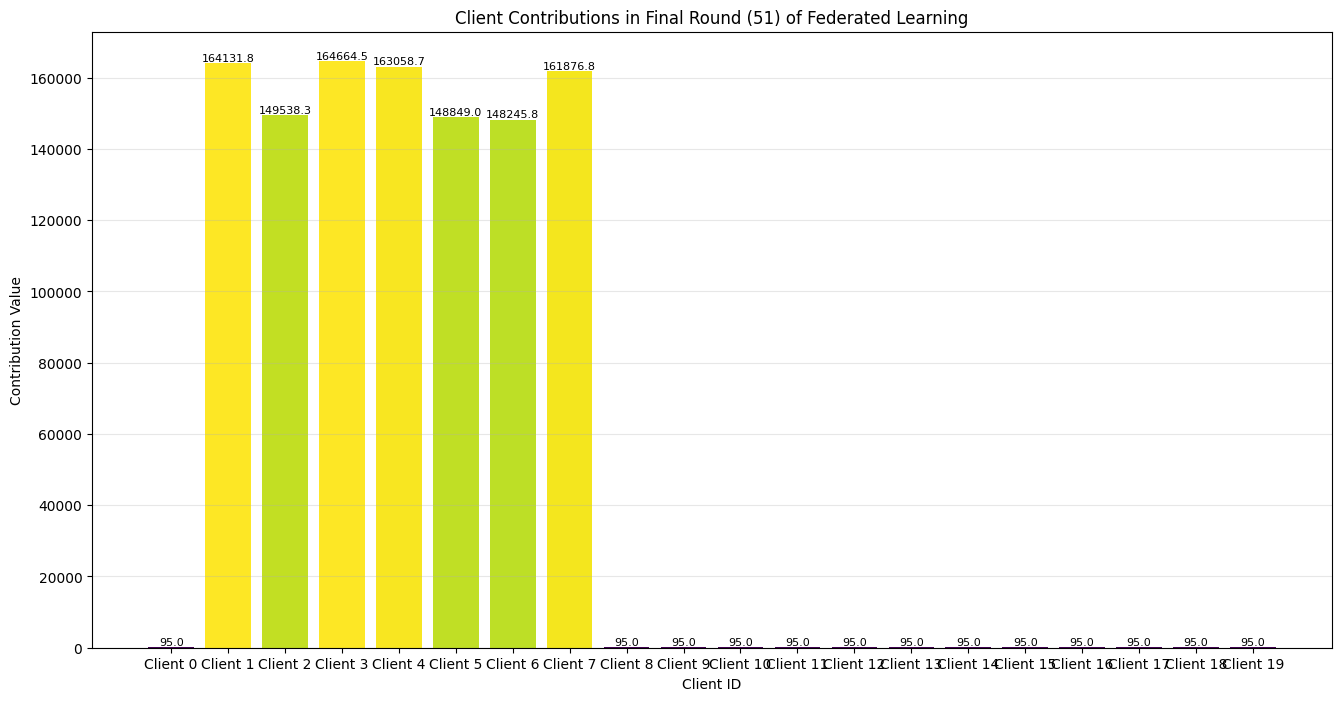

In [24]:
import matplotlib.pyplot as plt
import numpy as np

main_dict = pickle.load(open("main_dict_20_10.0.pkl", "rb"))
global_accuracy_history = main_dict["global_accuracy_history"]
# 模拟数据生成
num_rounds = len(global_accuracy_history) # 联邦学习轮次
num_clients = len(role_history[0].keys()) # 客户端数量

# 生成随机贡献数据 (100x100)
contributions = main_dict["contribution_history"]
# 提取最后一轮的贡献值
def client_to_nums(client: str):
    if client.startswith("client"):
        return int(client[7:])
    elif client.startswith("bad_client"):
        return 100 + int(client[11:])
    else:
        return -1
last_round_contributions = list(j for _, j in sorted(contributions[-1].items(), key=lambda x: client_to_nums(x[0])))
last_round_contributions = np.array(last_round_contributions)

print(last_round_contributions.shape)

# 创建图形
plt.figure(figsize=(16, 8))

# 创建条形图
bars = plt.bar(
    x=np.arange(num_clients),
    height=last_round_contributions,
    color=plt.cm.viridis(last_round_contributions / max(last_round_contributions))
)

# 添加贡献值标签（只显示前20个客户端，避免拥挤）
for i in range(num_clients):
    plt.text(
        i, 
        last_round_contributions[i] + 0.5, 
        f'{last_round_contributions[i]:.1f}', 
        ha='center', 
        va='bottom',
        fontsize=8
    )

# 设置图形属性
plt.title(f'Client Contributions in Final Round ({num_rounds}) of Federated Learning')
plt.xlabel('Client ID')
plt.ylabel('Contribution Value')
plt.xticks(np.arange(0, num_clients), [f'Client {i}' for i in range(0, num_clients)])
plt.grid(axis='y', alpha=0.3)

# 添加颜色条
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=max(last_round_contributions)))
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Contribution Value')

plt.tight_layout()
plt.show()